# Bayesian workflow with SEIR model (base case)

TODO: Change plots so that we're only looking at infectious individuals. Plot prior, intervened, calibrated, and optimized on same plot with vertical lines for time of intervention, and horizontal lines for threshold.

### Load dependencies from MIRA and PyCIEMSS

In [1]:
import os
import json
import requests
import sympy
import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from typing import Dict, List, Callable

# MIRA modeling dependencies
from mira.metamodel import *
from mira.metamodel.ops import stratify
from mira.examples.concepts import susceptible, exposed, infected, recovered
from mira.modeling import Model
from mira.modeling.amr.petrinet import AMRPetriNetModel, template_model_to_petrinet_json
from mira.sources.amr.petrinet import template_model_from_amr_json
from mira.metamodel.io import model_to_json_file, model_from_json_file
import sys
# PyCIEMSS dependencies
sys.path.insert(0, '../../pyciemss')
import pyciemss
import pyciemss.visuals.plots as plots
import pyciemss.visuals.vega as vega
import pyciemss.visuals.trajectories as trajectories
import pyciemss.visuals.histogram as histogram
from pyciemss.integration_utils.intervention_builder import (
    param_value_objective,
    start_time_objective,
)
from pyciemss.ouu.qoi import obs_max_qoi, obs_nday_average_qoi

# Set limited_mode to True to run with smaller number of samples/iterations
limited_mode = False

# Build SEIR model with MIRA

### Define units

In [2]:
person_units = lambda: Unit(expression=sympy.Symbol('person'))
day_units = lambda: Unit(expression=sympy.Symbol('day'))
per_day_units = lambda: Unit(expression=1/sympy.Symbol('day'))
dimensionless_units = lambda: Unit(expression=sympy.Integer('1'))

### Define concepts

In [3]:
c = {
    "S": Concept(name="S", units=person_units(), identifiers={"ido": "0000514"}), # susceptible
    "E": Concept(name="E", units=person_units(), identifiers={"apollosv": "0000154"}), # exposed
    "I": Concept(name="I", units=person_units(), identifiers={"ido": "0000511"}), # infectious
    "R": Concept(name="R", units=person_units(), identifiers={"ido": "0000592"}), # recovered
}

for concept in c:
    c[concept].name = concept

### Define model parameters

In [4]:
total_population = 100_000.0
I0_guess = 10.0

parameters = {
    'beta': Parameter(name='beta', value=sympy.Float(0.38), units=per_day_units(),
                      distribution=Distribution(type='StandardUniform1',
                                                parameters={'minimum': 0.35,
                                                            'maximum': 0.4})),  # Transmission rate S -> E by contact with I

    'N': Parameter(name='N', value=sympy.Float(total_population), units=dimensionless_units()),  # Total population

    'I0': Parameter(name='I0', value=sympy.Float(I0_guess), units=per_day_units(),
                     distribution=Distribution(type='StandardUniform1',
                                                parameters={'minimum': 1.0,
                                                            'maximum': 20.0})),  # Initial infectious population, 1 - 20 people
    
    'sigma': Parameter(name='sigma', value=sympy.Float(0.5), units=per_day_units()),  # Rate of progressing E -> I, latency period = 2 days
    
    'gamma': Parameter(name='gamma', value=sympy.Float(0.25), units=per_day_units(),
                     distribution=Distribution(type='StandardUniform1',
                                                parameters={'minimum': 0.1667,
                                                            'maximum': 0.3333})),  # Rate of progressing I -> R, infectious period = 3 - 6 days
}

### Define `SymPy` symbols

In [5]:
S, E, I, R, beta, N, I0, sigma, gamma = sympy.symbols('S E I R beta N I0 sigma gamma')

### Set initial conditions

In [6]:
initials = {
    "S": Initial(concept=c["S"], expression=total_population - 4*I0),
    "E": Initial(concept=c["E"], expression=3*I0),
    "I": Initial(concept=c["I"], expression=I0),
    "R": Initial(concept=c["R"], expression=0),
}

### Define model templates

In [7]:
#### S -> E
se = ControlledConversion(
    subject=c['S'],
    outcome=c['E'],
    controller=c['I'],
    rate_law=beta*S*I/N
)


#### E -> I
ei = NaturalConversion(
    subject=c['E'],
    outcome=c['I'],
    rate_law=sigma*E
)


#### I -> R
ir = NaturalConversion(
    subject=c['I'],
    outcome=c['R'],
    rate_law=gamma*I
)

### Define template model and save as a petrinet AMR

In [8]:
seir_model = TemplateModel(
    templates=[
        se,
        ei,
        ir
    ],
    parameters=parameters,
    initials=initials,
    time=Time(name='t', units=day_units()),
    observables={},
    annotations=Annotations(name='SEIR model (base case)')
)

# Save as JSON
with open("models/seir_model.json", 'w') as fh:
    json.dump(template_model_to_petrinet_json(seir_model), fh, indent=1)

# Simulate the model with `PyCIEMSS`

### Set model path and parameters for sampling

In [9]:
model = "models/seir_model.json"
num_samples = 100 if limited_mode else 10000
start_time = 0.0
end_time = 180.0
logging_step_size = 1.0

### Sample from model prior and plot the result

In [32]:


import pyciemss
import pyciemss.visuals.plots as plots
import pyciemss.visuals.vega as vega
import pyciemss.visuals.trajectories as trajectories
import pyciemss.visuals.histogram as histogram
from pyciemss.integration_utils.intervention_builder import (
    param_value_objective,
    start_time_objective,
)
from pyciemss.ouu.qoi import obs_max_qoi, obs_nday_average_qoi

# Set limited_mode to True to run with smaller number of samples/iterations
limited_mode = True
result = pyciemss.sample(model, end_time, logging_step_size, num_samples, start_time=start_time)
display(result['data'].head())
print(num_samples)




,timepoint_id,sample_id,timepoint_unknown,persistent_beta_param,persistent_gamma_param,persistent_I0_param,persistent_N_param,persistent_sigma_param,S_state,I_state,E_state,R_state
0,0,0,0.0,0.370215,0.167402,18.289684,100000.0,0.5,99926.843750,18.289684,54.869053,0.000000
1,1,0,1.0,0.370215,0.167402,18.289684,100000.0,0.5,99916.289062,37.128731,41.803406,4.772187
2,2,0,2.0,0.370215,0.167402,18.289684,100000.0,0.5,99900.140625,49.559822,38.212967,12.081485
3,3,0,3.0,0.370215,0.167402,18.289684,100000.0,0.5,99880.039062,59.628471,39.214218,21.236841
4,4,0,4.0,0.370215,0.167402,18.289684,100000.0,0.5,99855.992188,69.232796,42.643539,32.020969


10000


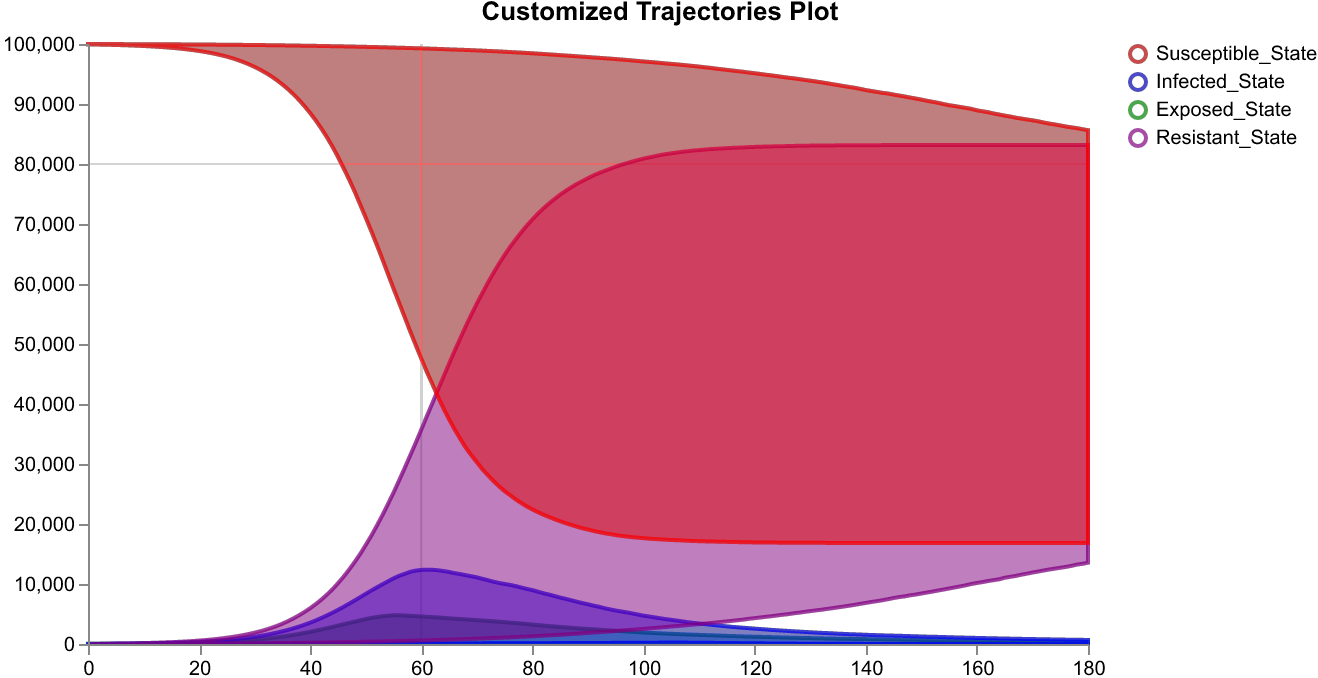

In [50]:

import pyciemss
import pyciemss.visuals.plots as plots
import pyciemss.visuals.vega as vega
import pyciemss.visuals.trajectories as trajectories
import pyciemss.visuals.histogram as histogram
from pyciemss.integration_utils.intervention_builder import (
    param_value_objective,
    start_time_objective,
)
from pyciemss.ouu.qoi import obs_max_qoi, obs_nday_average_qoi

# Define custom colors for states
colors = {
    "Susceptible_State": "red",
    "Infected_State": "blue",
    "Exposed_State": "green",
    "Resistant_State": "purple"
}

# Define markers for vertical and horizontal lines
base_markers_v = {"Intervention": 60}
base_markers_h = {"Threshold": 80000}

# Relabel states for the legend
relabel = {
    "S_state": "Susceptible_State",
    "I_state": "Infected_State",
    "E_state": "Exposed_State",
    "R_state": "Resistant_State"
}

# Plot results with additional customizations
schema = plots.trajectories(
    result["data"],
    keep=".*_state",
    title="Customized Trajectories Plot",
    colors=colors,
    base_markers_v=base_markers_v,
    base_markers_h=base_markers_h,
    relabel=relabel
)

with open("figures/trajectory_example.json", "w") as f:
    json.dump(schema, f, indent=2)
# Save and display the image
img = plots.ipy_display(schema, format="png")
with open("figures/customized_trajectories.png", "wb") as png:
    png.write(img.data)
plots.ipy_display(schema, dpi=150)

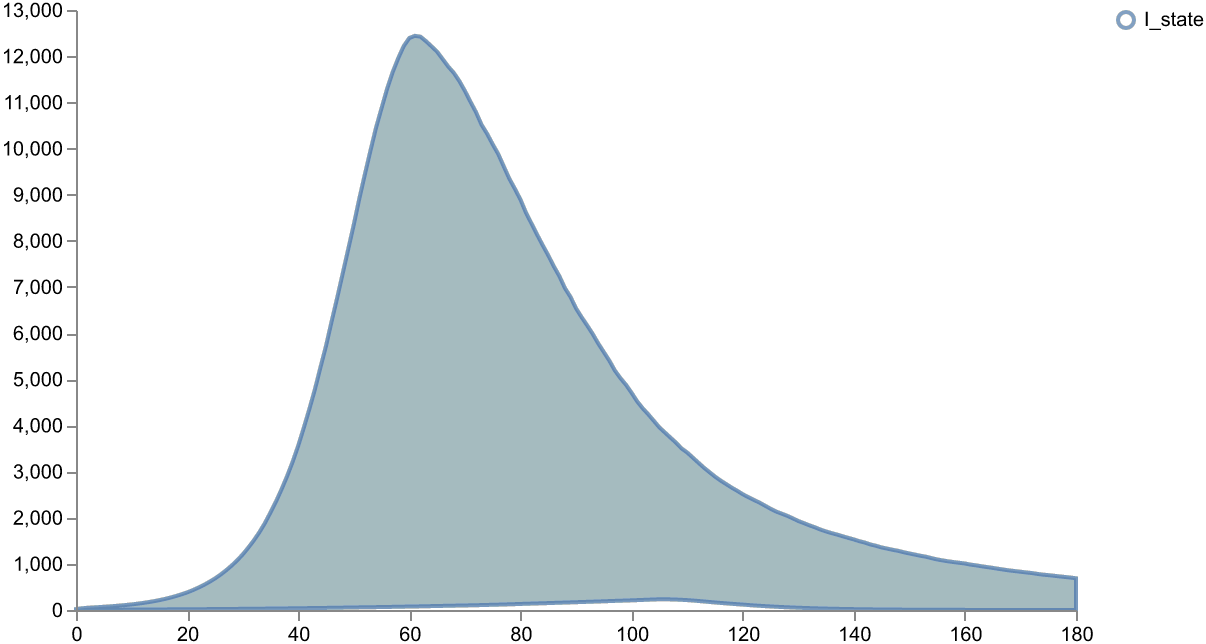

In [11]:
schema = plots.trajectories(result["data"], keep="I_state")
img = plots.ipy_display(schema, format="png")
with open("figures/seir_prior.png", "wb") as png:
    png.write(img.data)
plots.ipy_display(schema, dpi=150)

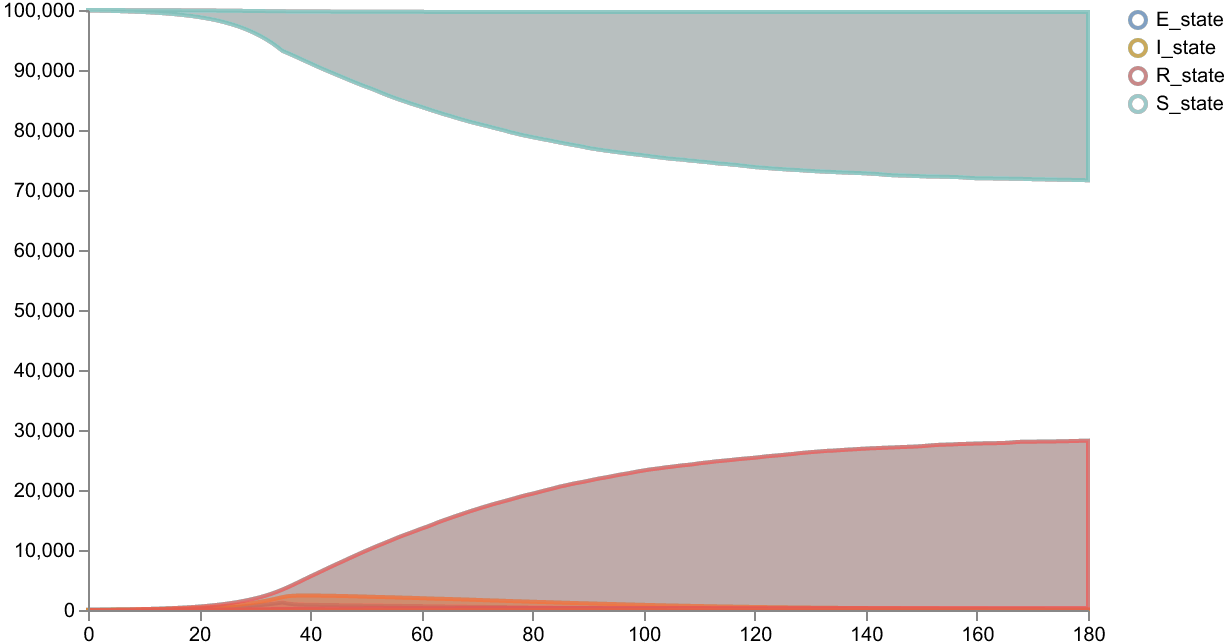

In [12]:
# Decrease the transmission rate by 50% after 35 days
intervened_sample_results1 = pyciemss.sample(
    model, end_time, logging_step_size, num_samples, start_time=start_time,
    static_parameter_interventions = {torch.tensor(35.0): {"beta": lambda x : x*0.5}}
)

# Plot result
schema = plots.trajectories(
    intervened_sample_results1["data"], 
    keep=".*_state"
)
img = plots.ipy_display(schema, format="png")
with open("figures/seir_intervened.png", "wb") as png:
    png.write(img.data)
plots.ipy_display(schema, dpi=150)

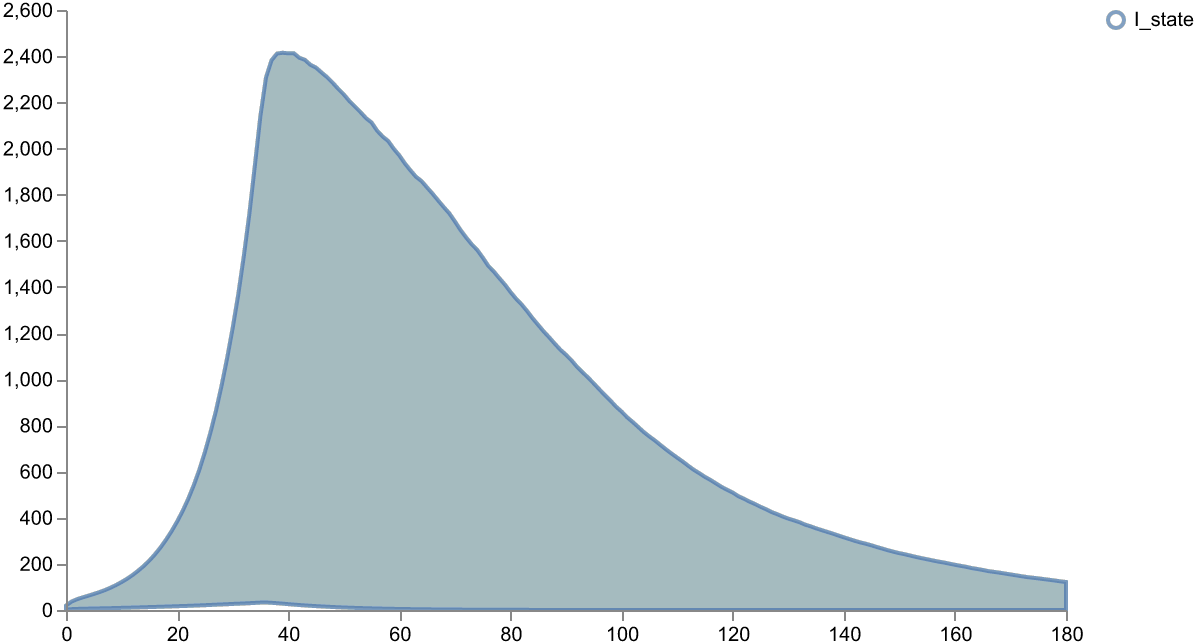

In [13]:
# Plot result
schema = plots.trajectories(
    intervened_sample_results1["data"], 
    keep="I_state"
)
img = plots.ipy_display(schema, format="png")
with open("figures/seir_intervened.png", "wb") as png:
    png.write(img.data)
plots.ipy_display(schema, dpi=150)

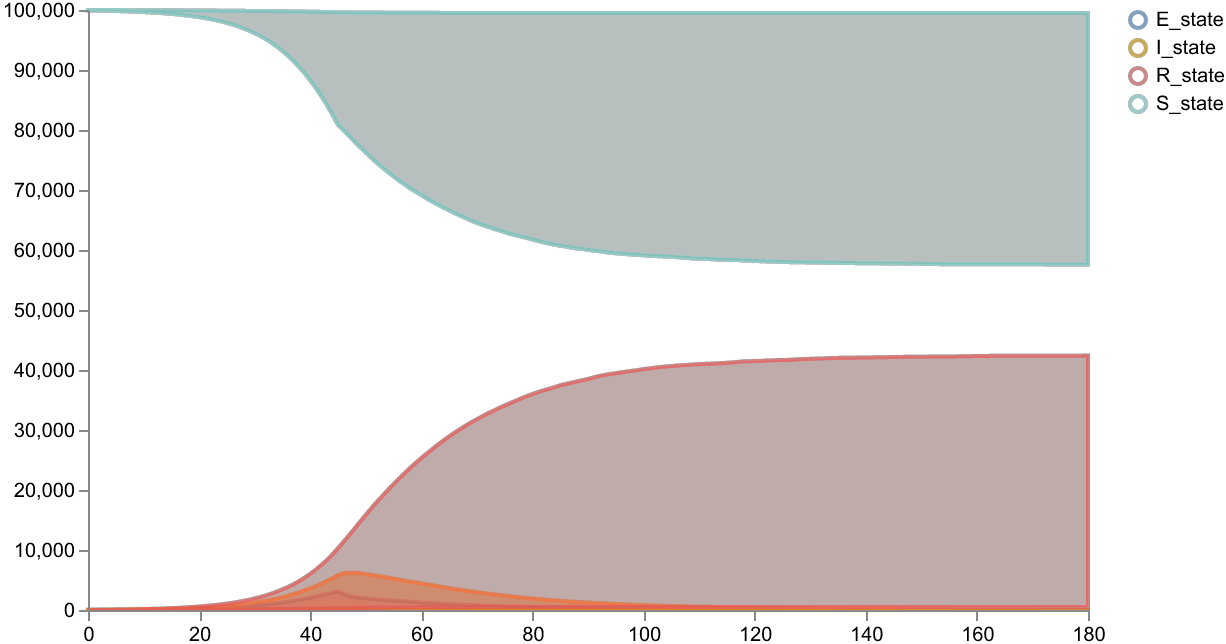

In [14]:
# Decrease the transmission rate by 50% after 45 days
intervened_sample_results1 = pyciemss.sample(
    model, end_time, logging_step_size, num_samples, start_time=start_time,
    static_parameter_interventions = {torch.tensor(45.0): {"beta": lambda x : x*0.5}}
)

# Plot result
schema = plots.trajectories(
    intervened_sample_results1["data"], 
    keep=".*_state"
)
img = plots.ipy_display(schema, format="png")
with open("figures/seir_intervened.png", "wb") as png:
    png.write(img.data)
plots.ipy_display(schema, dpi=150)

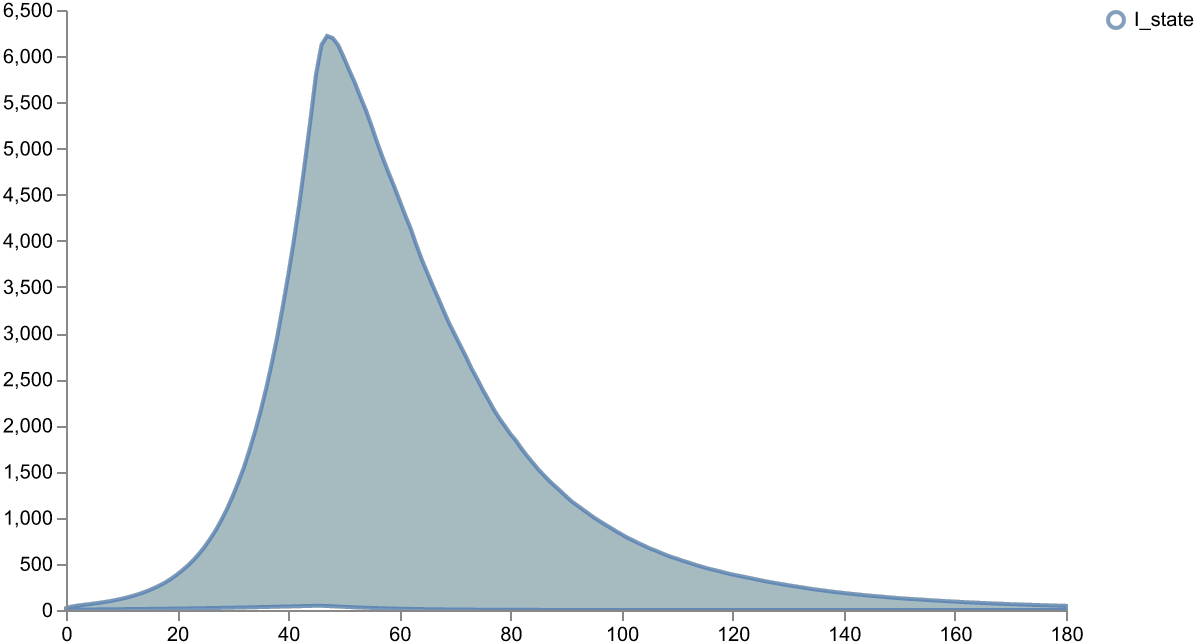

In [15]:
# Plot result
schema = plots.trajectories(
    intervened_sample_results1["data"], 
    keep="I_state"
)
img = plots.ipy_display(schema, format="png")
with open("figures/seir_intervened.png", "wb") as png:
    png.write(img.data)
plots.ipy_display(schema, dpi=150)

### Sample from the model with an intervention: transmission rate drops to 0.35 at day 45.

,timepoint_id,sample_id,timepoint_unknown,persistent_beta_param,persistent_gamma_param,persistent_I0_param,persistent_N_param,persistent_sigma_param,S_state,I_state,E_state,R_state
0,0,0,0.0,0.373074,0.207737,7.555404,100000.0,0.5,99969.781250,7.555404,22.666210,0.000000
1,1,0,1.0,0.373074,0.207737,7.555404,100000.0,0.5,99965.484375,14.900462,17.233929,2.405070
2,2,0,2.0,0.373074,0.207737,7.555404,100000.0,0.5,99959.023438,19.407942,15.584170,5.998761
3,3,0,3.0,0.373074,0.207737,7.555404,100000.0,0.5,99951.117188,22.785755,15.699657,10.392352
4,4,0,4.0,0.373074,0.207737,7.555404,100000.0,0.5,99942.054688,25.807941,16.691540,15.441926


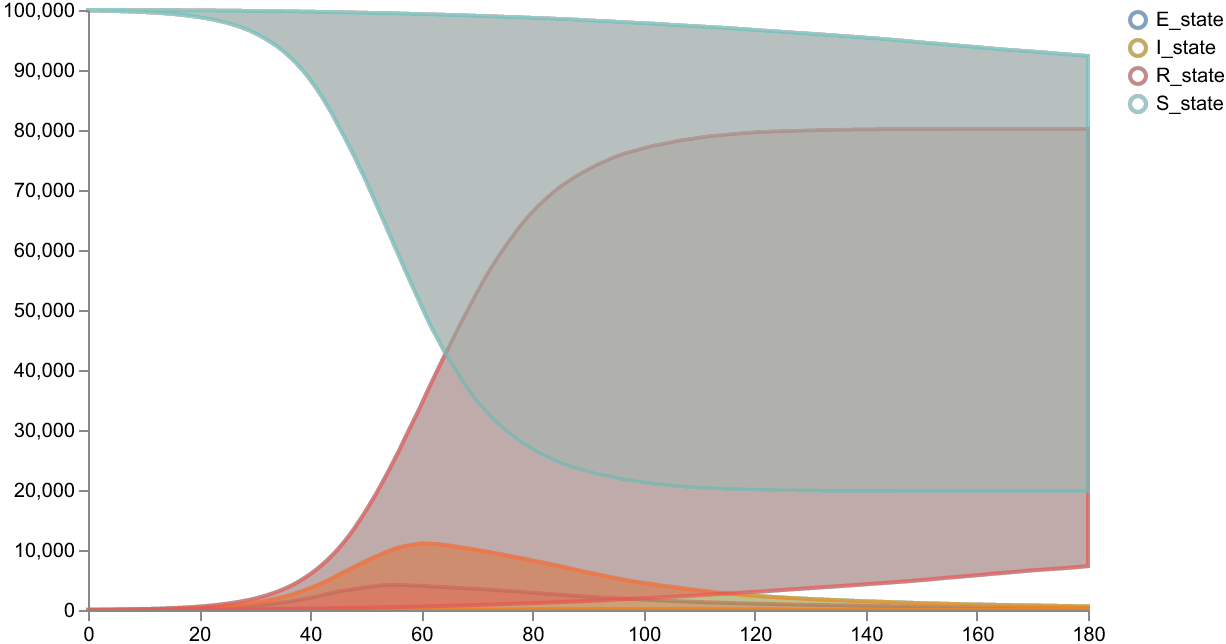

In [16]:
result_with_intervention = pyciemss.sample(model, end_time, logging_step_size, num_samples, start_time=start_time, 
                         static_parameter_interventions={torch.tensor(45.0): {"beta": torch.tensor(0.35)}}
                        )
display(result_with_intervention['data'].head())

# Plot results for all states
schema = plots.trajectories(result_with_intervention["data"], keep=".*_state")
img = plots.ipy_display(schema, format="png")
with open("figures/seir_prior_with_intervention.png", "wb") as png:
    png.write(img.data)
plots.ipy_display(schema, dpi=150)

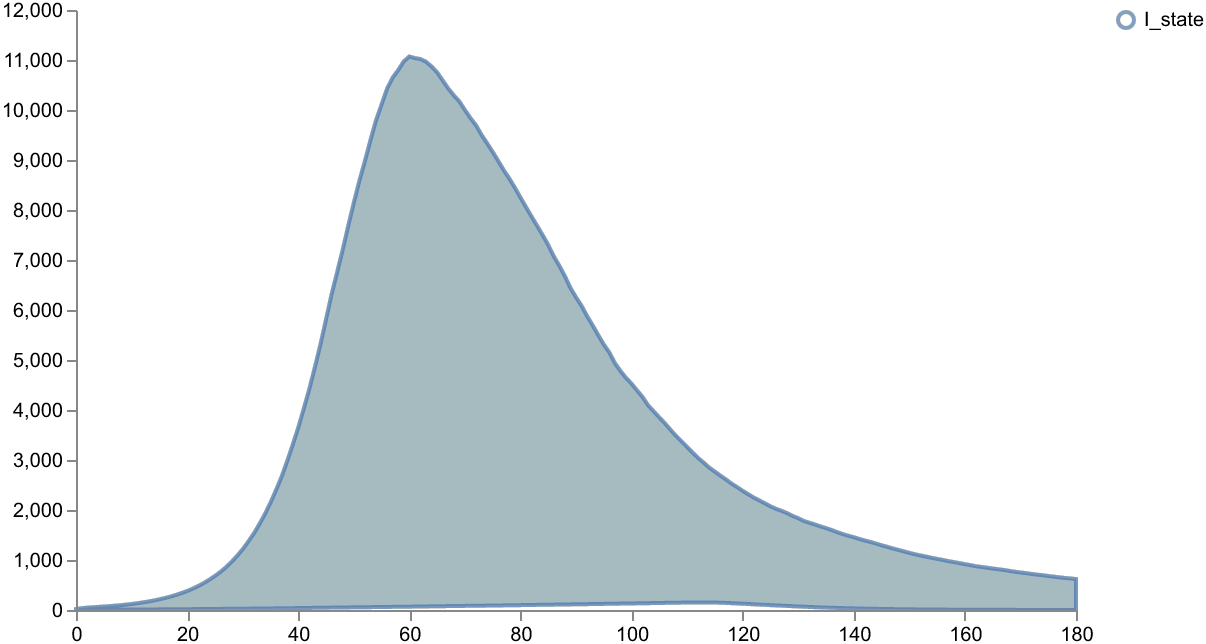

In [17]:
# Plot results for I state with intervention
schema = plots.trajectories(result_with_intervention["data"], keep="I_state")
img = plots.ipy_display(schema, format="png")
with open("figures/seir_prior_I_state_with_intervention.png", "wb") as png:
    png.write(img.data)
plots.ipy_display(schema, dpi=150)

# Generate synthetic data

### Remove uncertainty from transmission rate `beta`, recovery rate `gamma`, and initial infectious population `I0`

In [18]:
print(f"beta value: {seir_model.parameters['beta'].value}")
beta_const_value = seir_model.parameters['beta'].value
print(f"beta prior distribution: {seir_model.parameters['beta'].distribution}")
beta_prior_min = seir_model.parameters['beta'].distribution.parameters["minimum"]
beta_prior_max = seir_model.parameters['beta'].distribution.parameters["maximum"]
seir_model.parameters['beta'].distribution = None

print(f"gamma value: {seir_model.parameters['gamma'].value}")
gamma_const_value = seir_model.parameters['gamma'].value
print(f"gamma prior distribution: {seir_model.parameters['gamma'].distribution}")
gamma_prior_min = seir_model.parameters['gamma'].distribution.parameters["minimum"]
gamma_prior_max = seir_model.parameters['gamma'].distribution.parameters["maximum"]
seir_model.parameters['gamma'].distribution = None

print(f"I0 value: {seir_model.parameters['I0'].value}")
I0_const_value = seir_model.parameters['I0'].value
print(f"I0 prior distribution: {seir_model.parameters['I0'].distribution}")
I0_prior_min = seir_model.parameters['I0'].distribution.parameters["minimum"]
I0_prior_max = seir_model.parameters['I0'].distribution.parameters["maximum"]
seir_model.parameters['I0'].distribution = None

# Save as updated AMR
with open('models/seir_model_constant_params.json', 'w') as fh:
    json.dump(template_model_to_petrinet_json(seir_model), fh, indent=1)

beta value: 0.38
beta prior distribution: type='StandardUniform1' parameters={'minimum': 0.35, 'maximum': 0.4}
gamma value: 0.25
gamma prior distribution: type='StandardUniform1' parameters={'minimum': 0.1667, 'maximum': 0.3333}
I0 value: 10.0
I0 prior distribution: type='StandardUniform1' parameters={'minimum': 1.0, 'maximum': 20.0}


### Take a single sample from the model with uncertainty removed

,timepoint_id,sample_id,timepoint_unknown,persistent_N_param,persistent_beta_param,persistent_sigma_param,persistent_gamma_param,persistent_I0_param,S_state,I_state,E_state,R_state
0,0,0,0.0,100000.0,0.38,0.5,0.25,10.0,99960.000000,10.000000,30.000000,0.000000
1,1,0,1.0,100000.0,0.38,0.5,0.25,10.0,99954.218750,19.146444,22.808632,3.764442
2,2,0,2.0,100000.0,0.38,0.5,0.25,10.0,99946.117188,24.345930,20.458473,9.251922
3,3,0,3.0,100000.0,0.38,0.5,0.25,10.0,99936.000000,27.919470,20.286766,15.805233
4,4,0,4.0,100000.0,0.38,0.5,0.25,10.0,99924.820312,30.888609,21.135740,23.162748


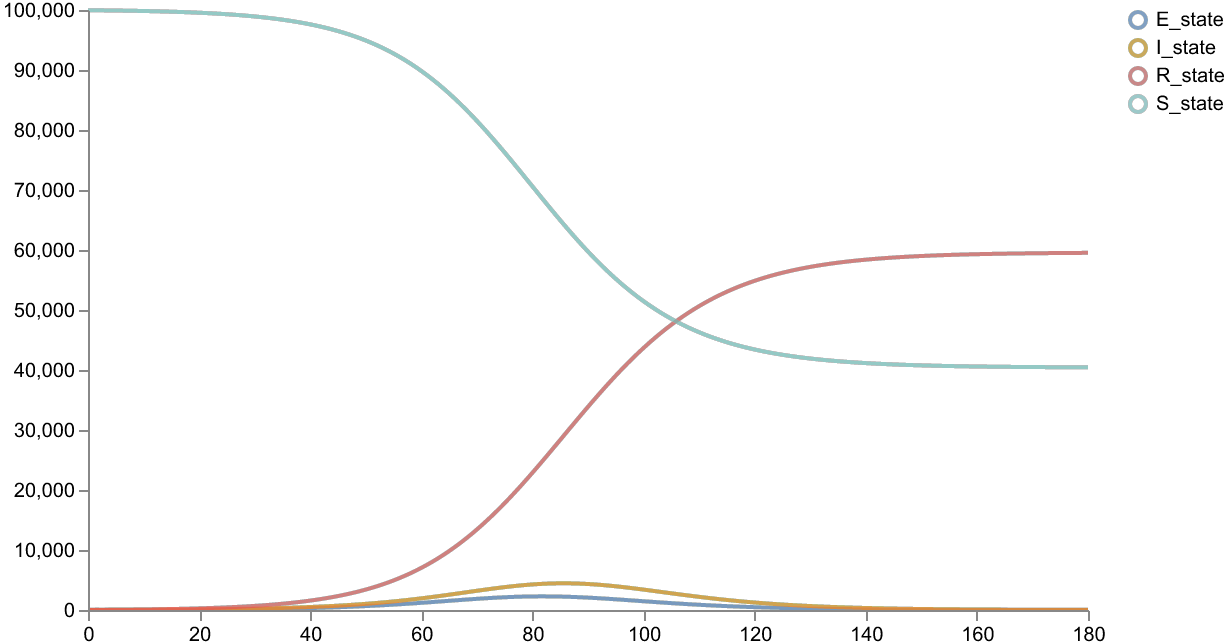

In [19]:
const_param_model = 'models/seir_model_constant_params.json'
result1 = pyciemss.sample(const_param_model, end_time, logging_step_size, 1, start_time=start_time)
display(result1['data'].head())

# Plot results for all states
schema = plots.trajectories(result1["data"], keep=".*_state")
img = plots.ipy_display(schema, format="png")
with open("figures/seir_constant_param_sample.png", "wb") as png:
    png.write(img.data)
plots.ipy_display(schema, dpi=150)

### Add uniformly distributed noise to simulated result for `I` and `R` states

In [20]:
noise_level = 0.15

# Uniform noise: U((1 - noise_level) * value, (1 + noise_level) * value)
df_uniform = result1['data'].copy()
df_uniform['I_state'] = df_uniform['I_state'] * np.random.uniform((1 - noise_level), (1 + noise_level), df_uniform['I_state'].shape)
df_uniform['R_state'] = df_uniform['R_state'] * np.random.uniform((1 - noise_level), (1 + noise_level), df_uniform['R_state'].shape)

# Make sure all values are positive and round to nearest decimal
df_uniform['I_state'] = df_uniform['I_state'].abs().round(1)
df_uniform['R_state'] = df_uniform['R_state'].abs().round(1)

# Create the new dataframe for uniform noise, keep up to time 60
uniform_df = pd.DataFrame({
    'Timestamp': df_uniform['timepoint_unknown'].iloc[:61],
    'I_data': df_uniform['I_state'].iloc[:61],
    'R_data': df_uniform['R_state'].iloc[:61]
})

# Save synthetic data
uniform_df.to_csv('datasets/seir_synth_data.csv', index=False)

### Plot single sample (without uncertainty) with synthetically generated data

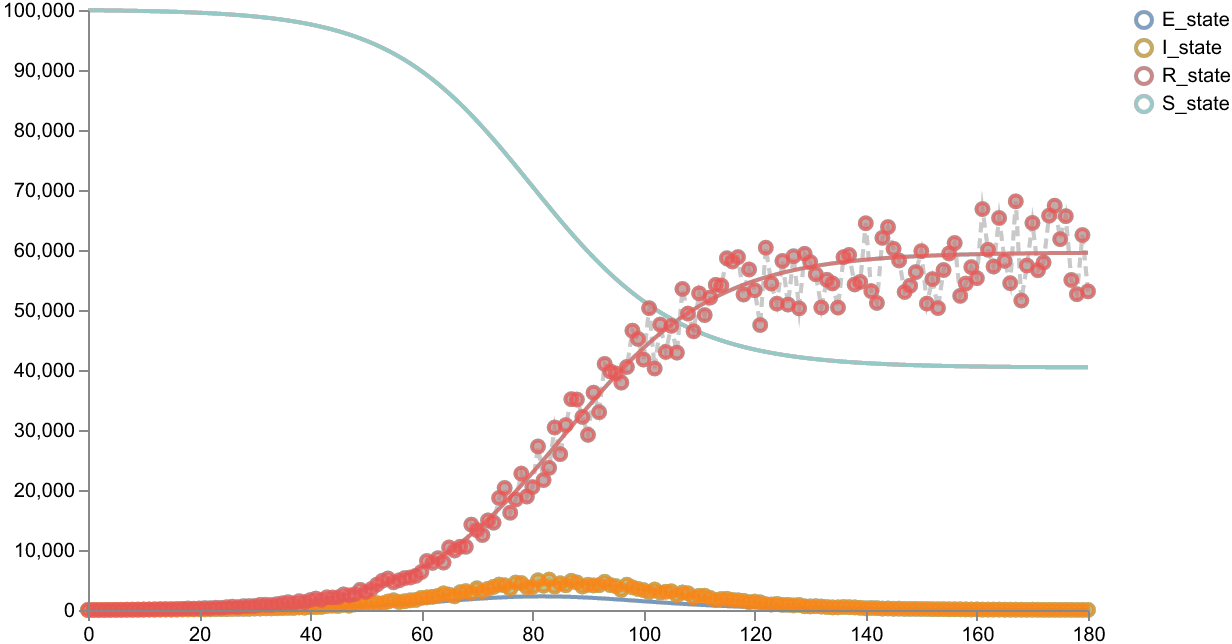

In [21]:
result2 = pyciemss.sample(const_param_model, end_time, logging_step_size, 1, start_time=start_time)
# display(calibrated_sample_result2['data'].head())

# Plot calibrated result
schema = plots.trajectories(
    result2["data"], 
    keep=".*_state", 
    points=df_uniform[["I_state", "R_state"]].reset_index(drop=True)
)
img = plots.ipy_display(schema, format="png")
with open("figures/seir_synth_data.png", "wb") as png:
    png.write(img.data)
plots.ipy_display(schema, dpi=150)

### Calibrate original model (with uncertainty) to synthetically generated data

Data printout: This dataset contains 60 rows of data. The first column, Timestamp, begins at 0.0 and ends at 60.0. The subsequent columns are named: I_data, R_data


,timepoint_id,sample_id,timepoint_unknown,persistent_beta_param,persistent_gamma_param,persistent_I0_param,persistent_N_param,persistent_sigma_param,S_state,I_state,E_state,R_state
0,0,0,0.0,0.377706,0.289115,7.89088,100000.0,0.5,99968.437500,7.890880,23.672640,0.000000
1,1,0,1.0,0.377706,0.289115,7.89088,100000.0,0.5,99964.000000,14.684306,17.913036,3.378749
2,2,0,2.0,0.377706,0.289115,7.89088,100000.0,0.5,99957.750000,18.220985,15.846452,8.184398
3,3,0,3.0,0.377706,0.289115,7.89088,100000.0,0.5,99950.437500,20.386711,15.393723,13.785723
4,4,0,4.0,0.377706,0.289115,7.89088,100000.0,0.5,99942.429688,21.995966,15.659949,19.920355


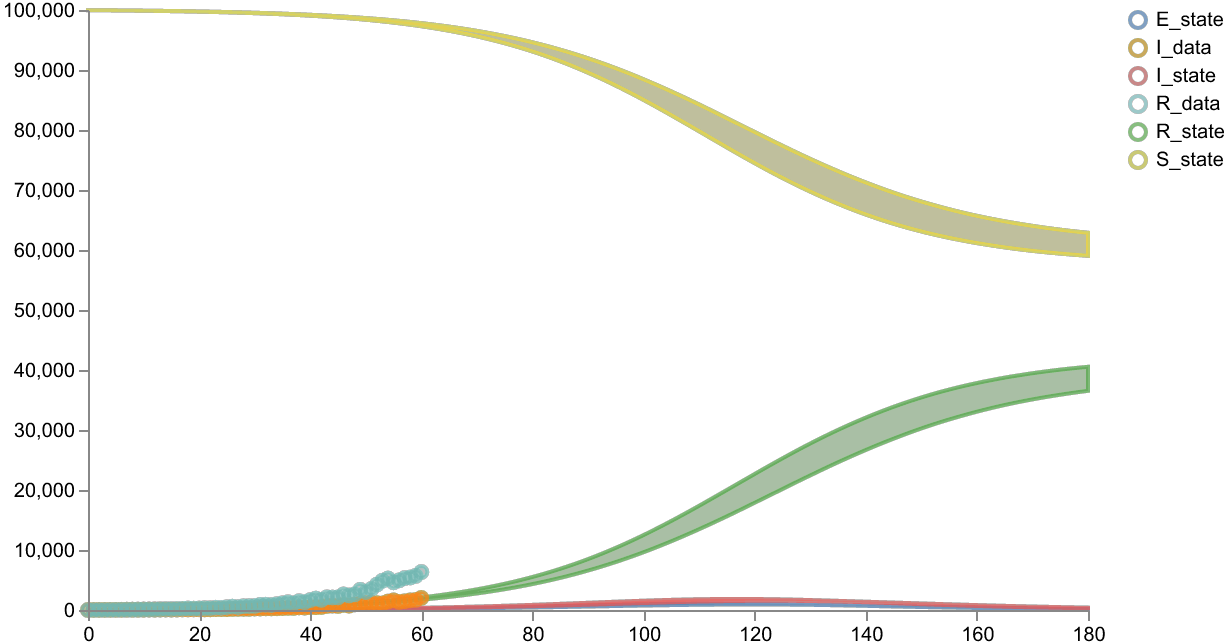

In [22]:
dataset = 'datasets/seir_synth_data.csv'
data_mapping = {'I_data': 'I', 'R_data': 'R'}
num_iterations = 5

calibrated_result = pyciemss.calibrate(model, dataset, data_mapping=data_mapping, num_iterations=num_iterations)
parameter_estimates = calibrated_result["inferred_parameters"]
# display(parameter_estimates())
    
calibrated_sample_result2 = pyciemss.sample(model, end_time, logging_step_size, num_samples, 
                                                start_time=start_time, inferred_parameters=parameter_estimates)
display(calibrated_sample_result2['data'].head())

# Plot calibrated result
data_df = pd.read_csv(dataset)
schema = plots.trajectories(
    calibrated_sample_result2["data"], 
    keep=".*_state", 
    points=data_df.drop(columns=['Timestamp']).reset_index(drop=True)
)
img = plots.ipy_display(schema, format="png")
with open("figures/seir_calibrated.png", "wb") as png:
    png.write(img.data)
plots.ipy_display(schema, dpi=150)

### Plot prior and calibrated parameter distributions

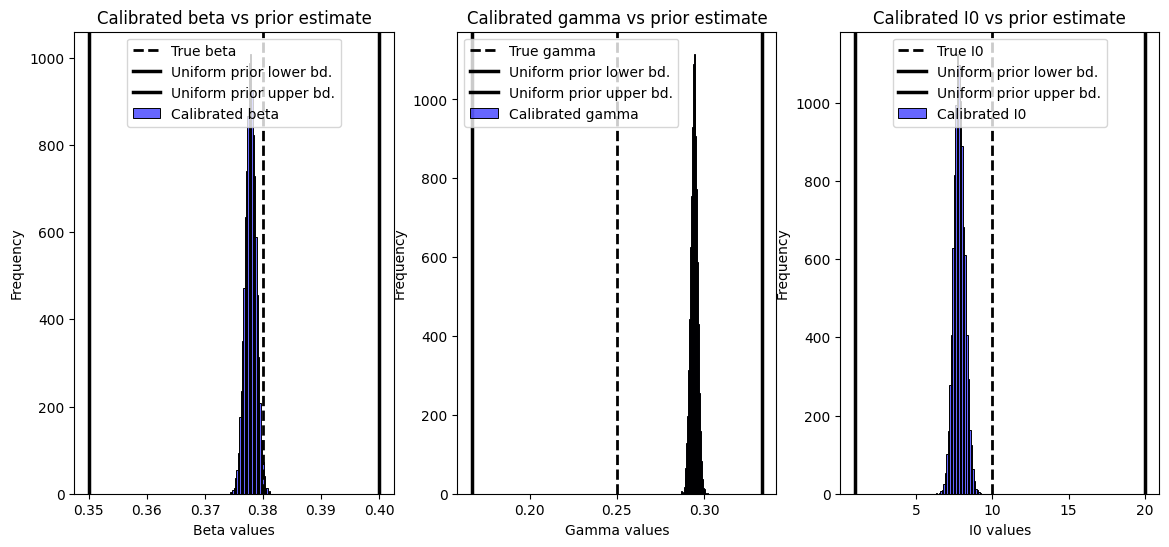

<Figure size 640x480 with 0 Axes>

In [23]:
# Extract unique values for each parameter
unique_beta_params = calibrated_sample_result2['data'][['sample_id', 'persistent_beta_param']].drop_duplicates()['persistent_beta_param']
unique_gamma_params = calibrated_sample_result2['data'][['sample_id', 'persistent_gamma_param']].drop_duplicates()['persistent_gamma_param']
unique_I0_params = calibrated_sample_result2['data'][['sample_id', 'persistent_I0_param']].drop_duplicates()['persistent_I0_param']

# Set up the plotting grid
fig, axs = plt.subplots(1, 3, figsize=(14, 6))

# Histogram of beta values
sns.histplot(unique_beta_params, kde=False, color='blue', bins=30, label='Calibrated beta', alpha=0.6, ax=axs[0])
axs[0].axvline(x=beta_const_value, color='black', linestyle='--', linewidth=2, label='True beta')
axs[0].axvline(x=beta_prior_min, color='black', linestyle='-', linewidth=2.5, label='Uniform prior lower bd.')
axs[0].axvline(x=beta_prior_max, color='black', linestyle='-', linewidth=2.5, label='Uniform prior upper bd.')
axs[0].set_xlabel('Beta values')
axs[0].set_ylabel('Frequency')
axs[0].set_title('Calibrated beta vs prior estimate')
axs[0].legend()

# Histogram of gamma values
sns.histplot(unique_gamma_params, kde=False, color='blue', bins=30, label='Calibrated gamma', alpha=0.6, ax=axs[1])
axs[1].axvline(x=gamma_const_value, color='black', linestyle='--', linewidth=2, label='True gamma')
axs[1].axvline(x=gamma_prior_min, color='black', linestyle='-', linewidth=2.5, label='Uniform prior lower bd.')
axs[1].axvline(x=gamma_prior_max, color='black', linestyle='-', linewidth=2.5, label='Uniform prior upper bd.')
axs[1].set_xlabel('Gamma values')
axs[1].set_ylabel('Frequency')
axs[1].set_title('Calibrated gamma vs prior estimate')
axs[1].legend()

# Histogram of I0 values
sns.histplot(unique_I0_params, kde=False, color='blue', bins=30, label='Calibrated I0', alpha=0.6, ax=axs[2])
axs[2].axvline(x=I0_const_value, color='black', linestyle='--', linewidth=2, label='True I0')
axs[2].axvline(x=I0_prior_min, color='black', linestyle='-', linewidth=2.5, label='Uniform prior lower bd.')
axs[2].axvline(x=I0_prior_max, color='black', linestyle='-', linewidth=2.5, label='Uniform prior upper bd.')
axs[2].set_xlabel('I0 values')
axs[2].set_ylabel('Frequency')
axs[2].set_title('Calibrated I0 vs prior estimate')
axs[2].legend()

# Show plot
plt.show()

# Save the plot as a PNG file
plt.savefig("figures/seir_calibrated_params.png", format="png")

# HELP!

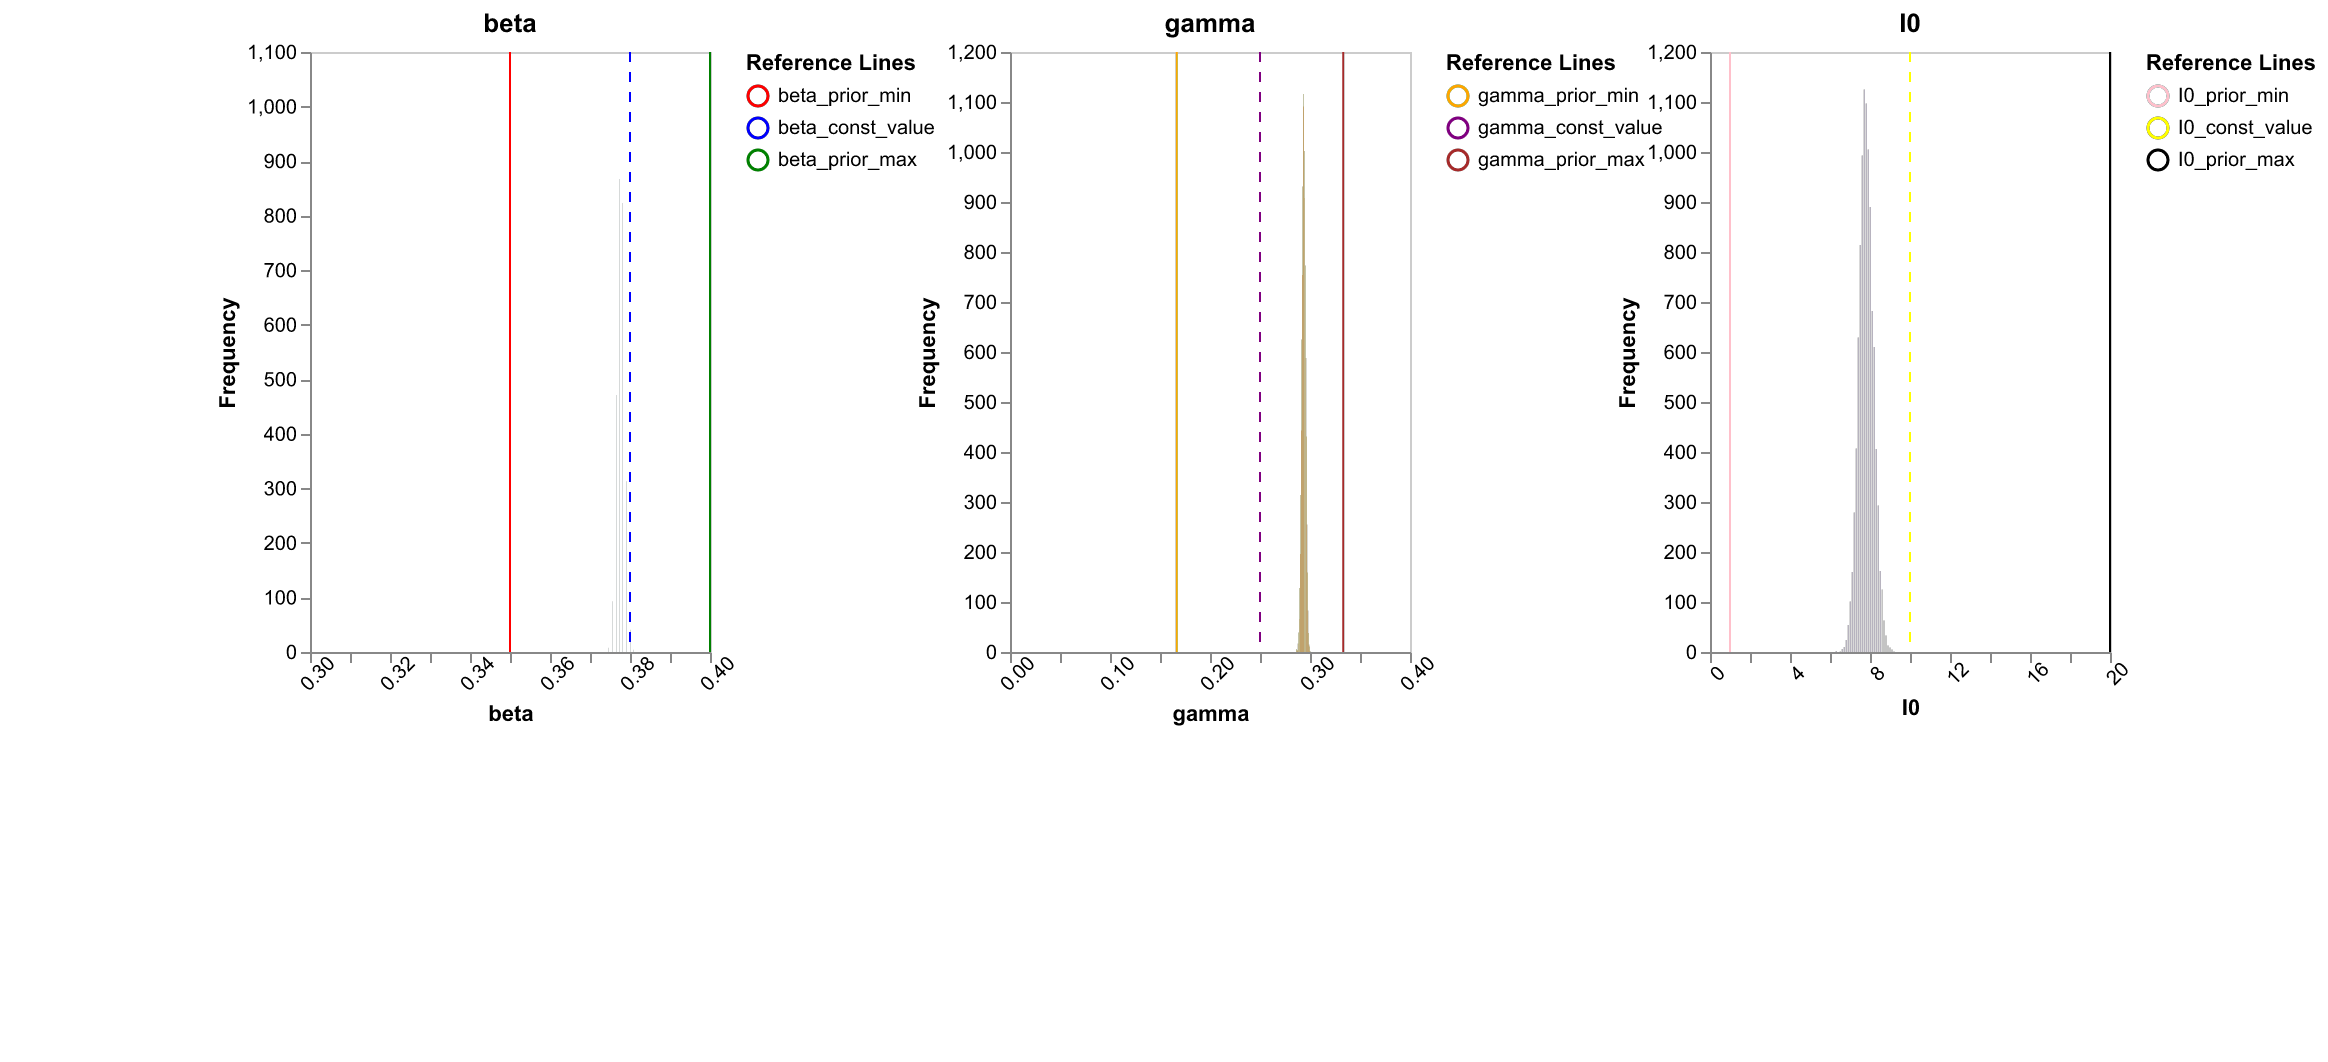

In [25]:
import os
import json
import requests
import sympy
import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from typing import Dict, List, Callable

# MIRA modeling dependencies
from mira.metamodel import *
from mira.metamodel.ops import stratify
from mira.examples.concepts import susceptible, exposed, infected, recovered
from mira.modeling import Model
from mira.modeling.amr.petrinet import AMRPetriNetModel, template_model_to_petrinet_json
from mira.sources.amr.petrinet import template_model_from_amr_json
from mira.metamodel.io import model_to_json_file, model_from_json_file

# PyCIEMSS dependencies
import sys
sys.path.insert(0, '../../pyciemss')
import pyciemss
import pyciemss.visuals.plots as plots
import pyciemss.visuals.vega as vega
import pyciemss.visuals.trajectories as trajectories
import pyciemss.visuals.histogram as histogram
from pyciemss.integration_utils.intervention_builder import (
    param_value_objective,
    start_time_objective,
)
from pyciemss.ouu.qoi import obs_max_qoi, obs_nday_average_qoi

# Set limited_mode to True to run with smaller number of samples/iterations
limited_mode = False
# Extract unique beta, gamma, and I0 values
unique_beta_params = calibrated_sample_result2['data'][['sample_id', 'persistent_beta_param']].drop_duplicates()['persistent_beta_param']
unique_gamma_params = calibrated_sample_result2['data'][['sample_id', 'persistent_gamma_param']].drop_duplicates()['persistent_gamma_param']
unique_I0_params = calibrated_sample_result2['data'][['sample_id', 'persistent_I0_param']].drop_duplicates()['persistent_I0_param']


# Combine histogram data into one dictionary
histogram_data = {
    "beta": unique_beta_params,
    "gamma": unique_gamma_params,
    "I0": unique_I0_params
}
yrefs_lines = [
    {"number": beta_prior_min, "name": "beta_prior_min", "color": "red", "type": "solid", "label": "beta"},
    {"number": beta_const_value, "name": "beta_const_value", "color": "blue", "type": "dashed", "label": "beta"},
    {"number": beta_prior_max, "name": "beta_prior_max", "color": "green", "type": "solid", "label": "beta"},
    {"number": gamma_prior_min, "name": "gamma_prior_min", "color": "orange", "type": "solid", "label": "gamma"},
    {"number": gamma_const_value, "name": "gamma_const_value", "color": "purple", "type": "dashed", "label": "gamma"},
    {"number": gamma_prior_max, "name": "gamma_prior_max", "color": "brown", "type": "solid", "label": "gamma"},
    {"number": I0_prior_min, "name": "I0_prior_min", "color": "pink", "type": "solid", "label": "I0"},
    {"number": I0_const_value, "name": "I0_const_value", "color": "yellow", "type": "dashed", "label": "I0"},
    {"number": I0_prior_max, "name": "I0_prior_max", "color": "black", "type": "solid", "label": "I0"}
]

axis_labels = {
        "beta": {"xaxis": "beta", "yaxis": "Frequency"},
        "gamma": {"xaxis": "gamma", "yaxis": "Frequency"},
        "I0": {"xaxis": "I0", "yaxis": "Frequency"}
      }

range_values = {
        "beta": {"min": .3, "max": .4},
        "gamma": {"min": 0, "max": .4},
        "I0": {"min": 0, "max": 20}
      }
# Plot histograms using in-built histogram_multi function
schema = histogram.histogram_subplots(
    yrefs=yrefs_lines,
    axis_labels = axis_labels,
    range = range_values,
    **histogram_data
)
with open("figures/seir_calibrated_params_schema.json", "w") as f:
    json.dump(schema, f, indent=2)
img = plots.ipy_display(schema, format="png")
with open("figures/seir_calibrated_params.png", "wb") as png:
    png.write(img.data)
plots.ipy_display(schema, dpi=150)

# Intervene on transmission rate

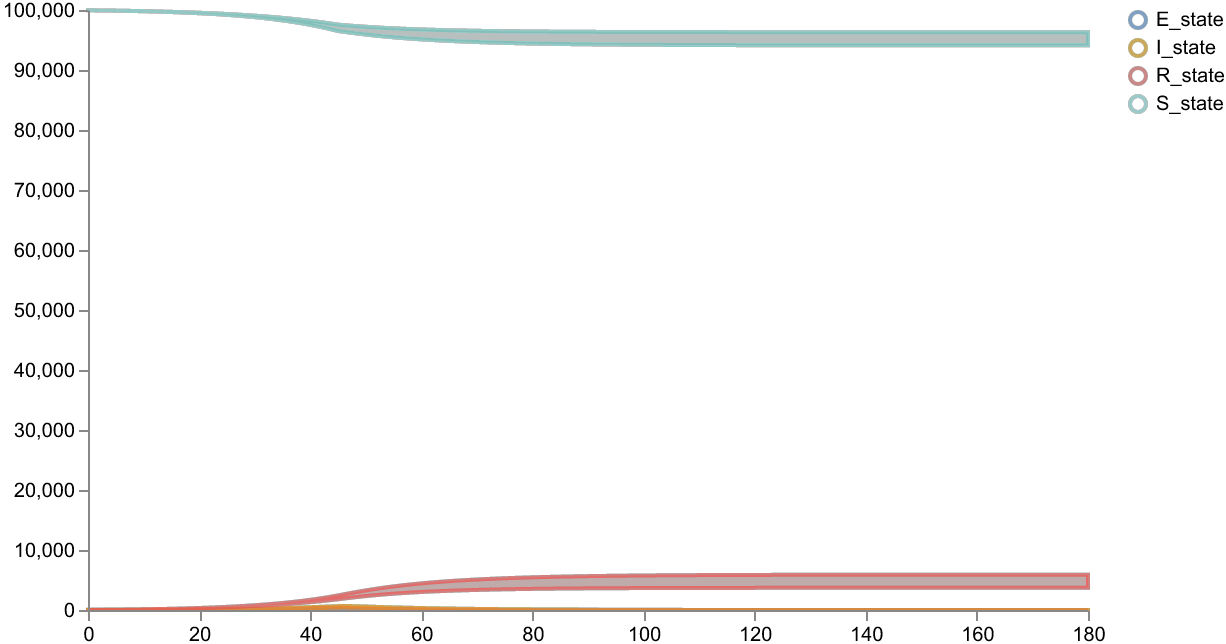

In [58]:
# Decrease the transmission rate by 50% after 45 days
intervened_sample_results1 = pyciemss.sample(
    model, end_time, logging_step_size, num_samples, start_time=start_time, 
    inferred_parameters=parameter_estimates,
    static_parameter_interventions = {torch.tensor(45.0): {"beta": lambda x : x*0.5}}
)

# Plot result
data_df = pd.read_csv(dataset)
schema = plots.trajectories(
    intervened_sample_results1["data"], 
    keep=".*_state", 
    # points=data_df.drop(columns=['Timestamp']).reset_index(drop=True)
)
img = plots.ipy_display(schema, format="png")
with open("figures/seir_intervened.png", "wb") as png:
    png.write(img.data)
plots.ipy_display(schema, dpi=150)

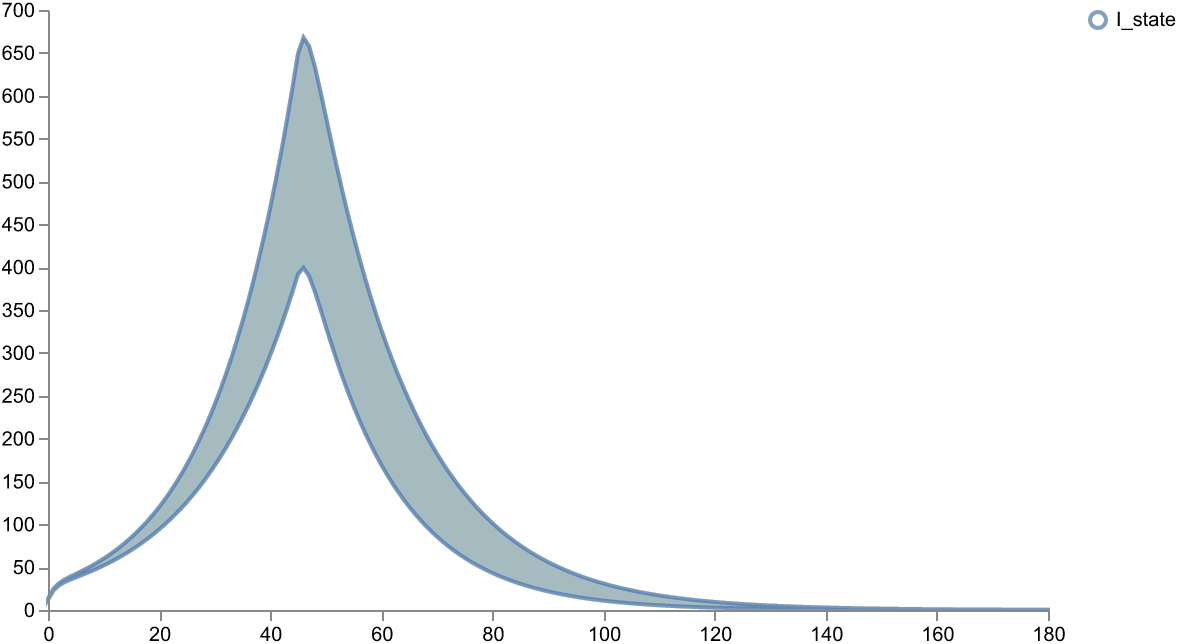

In [59]:
# Plot result
data_df = pd.read_csv(dataset)
schema = plots.trajectories(
    intervened_sample_results1["data"], 
    keep="I_state", 
    # points=data_df.drop(columns=['Timestamp']).reset_index(drop=True)
)
img = plots.ipy_display(schema, format="png")
with open("figures/seir_intervened_I_state.png", "wb") as png:
    png.write(img.data)
plots.ipy_display(schema, dpi=150)

# Optimization under uncertainty

## _Problem Statement:_ Find the minimal change in transmission rate `beta` at 45 days such that the infectious population does not exceed 3,500

### Set optimization parameters

In [60]:
num_samples_ouu = 100 if limited_mode else 1000 # controls accuracy of risk estimation in each optimization iteration
maxiter = 10 if limited_mode else 50 # maximum number of restarts of local convex optimizer leading to maxiter + 1 local optimizations
maxfeval = 25 if limited_mode else 100 # maximum number of function evaluations in each instance of local convex optimization

### Run optimization for `beta`

In [61]:
# Define optimization problem setup
observed_params = ["I_state"]
intervention_time = [torch.tensor(45.0)]
intervened_params = ["beta"]
current_param_value = beta_const_value
initial_guess_interventions = 0.3
bounds_interventions = [[0.2], [beta_const_value + 0.01]]
static_parameter_interventions = param_value_objective(
    param_name = intervened_params,
    param_value = [lambda x: torch.tensor(x)],
    start_time = intervention_time,
)

# Keep infections below 3500
risk_bound = 3500.0
qoi = lambda y: obs_max_qoi(y, observed_params)

objfun = lambda x: np.abs(current_param_value - x)

# Run optimize interface
opt_result1 = pyciemss.optimize(
    model,
    end_time,
    logging_step_size,
    qoi,
    risk_bound,
    static_parameter_interventions,
    objfun,
    initial_guess_interventions=initial_guess_interventions,
    bounds_interventions=bounds_interventions,
    start_time=start_time,
    inferred_parameters=parameter_estimates,
    n_samples_ouu=num_samples_ouu,
    maxiter=maxiter,
    maxfeval=maxfeval,
)

print(f'Optimal policy:', opt_result1["policy"])
print(opt_result1)

/Users/oost464/Local_Project/pyciemss/pyciemss/ouu/ouu.py:127: UserWarning: Selected interventions are out of bounds. Will use a penalty instead of estimating risk.
  warnings.warn(
/Users/oost464/Local_Project/pyciemss/pyciemss/ouu/ouu.py:127: UserWarning: Selected interventions are out of bounds. Will use a penalty instead of estimating risk.
  warnings.warn(
/Users/oost464/Local_Project/pyciemss/pyciemss/ouu/ouu.py:127: UserWarning: Selected interventions are out of bounds. Will use a penalty instead of estimating risk.
  warnings.warn(
/Users/oost464/Local_Project/pyciemss/pyciemss/ouu/ouu.py:127: UserWarning: Selected interventions are out of bounds. Will use a penalty instead of estimating risk.
  warnings.warn(
/Users/oost464/Local_Project/pyciemss/pyciemss/ouu/ouu.py:127: UserWarning: Selected interventions are out of bounds. Will use a penalty instead of estimating risk.
  warnings.warn(
/Users/oost464/Local_Project/pyciemss/pyciemss/ouu/ouu.py:127: UserWarning: Selected inter

Optimal policy: tensor([0.3764], dtype=torch.float64)
{'policy': tensor([0.3764], dtype=torch.float64), 'OptResults':                     message: ['requested number of basinhopping iterations completed successfully']
                    success: True
                        fun: 0.0036345046467305964
                          x: [ 3.764e-01]
                        nit: 50
      minimization_failures: 27
                       nfev: 397
 lowest_optimization_result: message: Optimization terminated successfully.
                             success: True
                              status: 1
                                 fun: 0.0036345046467305964
                                   x: [ 3.764e-01]
                                nfev: 8
                               maxcv: 0.0}


### Sample with optimal intervention applied and plot the result

Intervention:  {45.0: {'beta': tensor([0.3764])}}
Risk associated with QoI: [array([-2349.7073  , -2338.041   , -2331.6902  , -2327.5522  ,
       -2324.2786  , -2321.279   , -2318.2917  , -2315.196   ,
       -2311.9324  , -2308.4668  , -2304.7764  , -2301.9387  ,
       -2300.842   , -2298.2856  , -2296.6458  , -2294.416   ,
       -2292.1702  , -2290.3179  , -2287.3962  , -2285.9775  ,
       -2282.305   , -2281.381   , -2276.8752  , -2276.5144  ,
       -2271.3618  , -2271.0857  , -2265.907   , -2264.913   ,
       -2260.133   , -2258.3333  , -2254.0217  , -2251.32    ,
       -2247.5547  , -2243.8467  , -2240.7117  , -2235.8838  ,
       -2233.472   , -2227.4014  , -2225.8137  , -2218.3672  ,
       -2217.714   , -2209.15    , -2208.7466  , -2200.0942  ,
       -2198.5051  , -2190.5222  , -2187.6045  , -2180.4062  ,
       -2176.006   , -2169.7175  , -2163.6675  , -2158.426   ,
       -2150.5461  , -2146.501   , -2136.5967  , -2133.91    ,
       -2121.7717  , -2120.6191  , -2106.

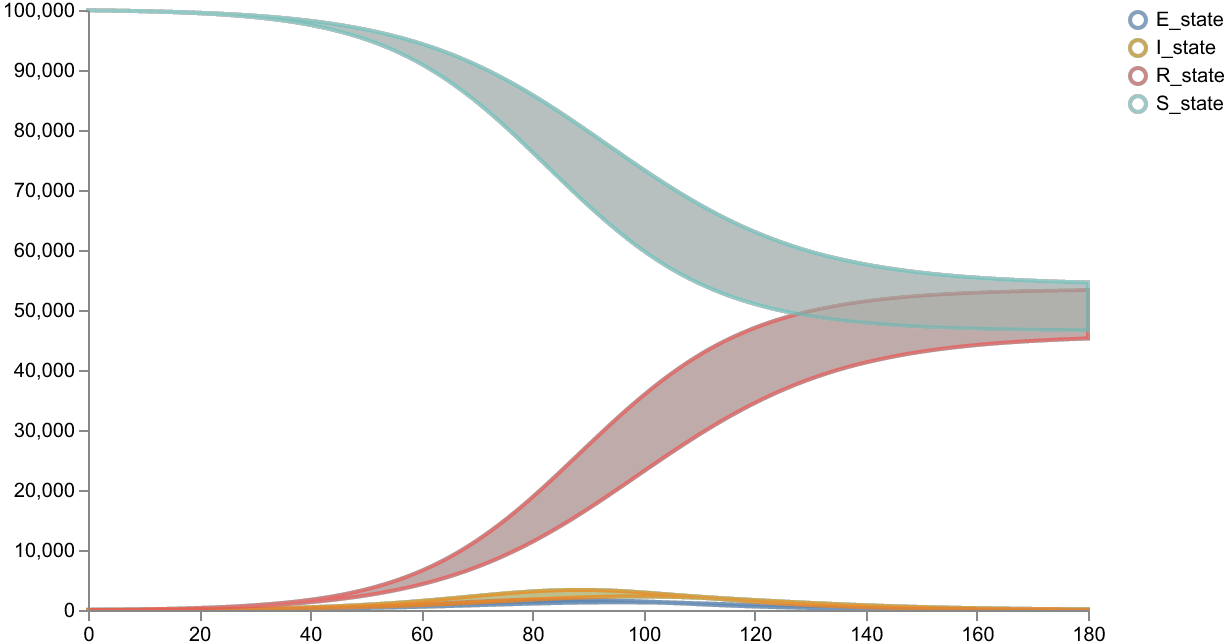

In [62]:
print("Intervention: ", static_parameter_interventions(opt_result1["policy"]))

opt_intervention_result1 = pyciemss.sample(
    model,
    end_time,
    logging_step_size,
    num_samples,
    start_time=start_time,
    inferred_parameters=parameter_estimates,
    static_parameter_interventions=static_parameter_interventions(opt_result1["policy"]),
)

# display(result1["data"])
print("Risk associated with QoI:", opt_intervention_result1["risk"][observed_params[0]]["risk"])

# Plot result
schema = plots.trajectories(
    opt_intervention_result1["data"], 
    keep=".*_state", 
)
img = plots.ipy_display(schema, format="png")
with open("figures/seir_optimized.png", "wb") as png:
    png.write(img.data)
plots.ipy_display(schema, dpi=150)

### Plot the result for the `I` state only

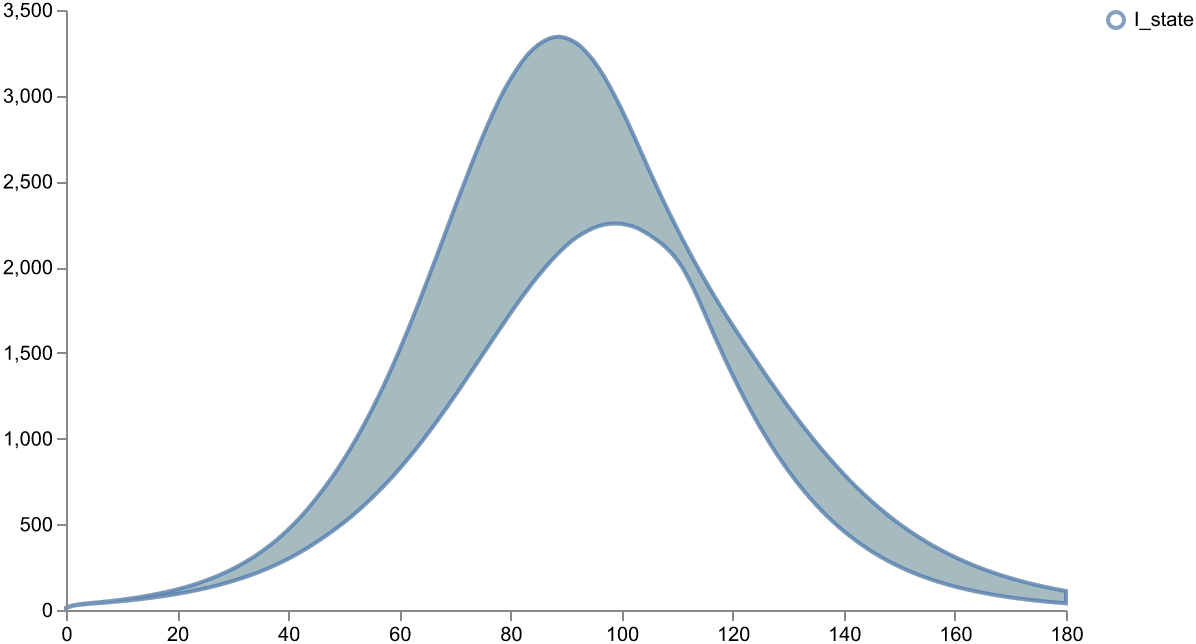

In [63]:
schema = plots.trajectories(
    opt_intervention_result1["data"], 
    keep="I_state", 
)
img = plots.ipy_display(schema, format="png")
with open("figures/seir_optimized_Istate.png", "wb") as png:
    png.write(img.data)
plots.ipy_display(schema, dpi=150)

# Optimize start time with intervention to reduce transmission by 10%

In [64]:
initial_guess_interventions = 0.1
bounds_interventions = [[start_time], [45.0]]

risk_bound = 3500.0
qoi = lambda y: obs_max_qoi(y, observed_params)
objfun = lambda x: -x

static_parameter_interventions = start_time_objective(
    param_name = intervened_params,
    param_value = torch.tensor([0.9*current_param_value]),
)
opt_result2 = pyciemss.optimize(
    model,
    end_time,
    logging_step_size,
    qoi,
    risk_bound,
    static_parameter_interventions,
    objfun,
    initial_guess_interventions=initial_guess_interventions,
    bounds_interventions=bounds_interventions,
    start_time=start_time,
    inferred_parameters=parameter_estimates,
    n_samples_ouu=num_samples_ouu,
    maxiter=maxiter,
    maxfeval=maxfeval
)

print(f'Optimal policy:', opt_result2["policy"])
print(opt_result2)

/Users/oost464/Local_Project/pyciemss/pyciemss/ouu/ouu.py:127: UserWarning: Selected interventions are out of bounds. Will use a penalty instead of estimating risk.
  warnings.warn(
/Users/oost464/Local_Project/pyciemss/pyciemss/ouu/ouu.py:127: UserWarning: Selected interventions are out of bounds. Will use a penalty instead of estimating risk.
  warnings.warn(
/Users/oost464/Local_Project/pyciemss/pyciemss/ouu/ouu.py:127: UserWarning: Selected interventions are out of bounds. Will use a penalty instead of estimating risk.
  warnings.warn(
/Users/oost464/Local_Project/pyciemss/pyciemss/ouu/ouu.py:127: UserWarning: Selected interventions are out of bounds. Will use a penalty instead of estimating risk.
  warnings.warn(
/Users/oost464/Local_Project/pyciemss/pyciemss/ouu/ouu.py:127: UserWarning: Selected interventions are out of bounds. Will use a penalty instead of estimating risk.
  warnings.warn(
/Users/oost464/Local_Project/pyciemss/pyciemss/ouu/ouu.py:127: UserWarning: Selected inter

Optimal policy: tensor([45.], dtype=torch.float64)
{'policy': tensor([45.], dtype=torch.float64), 'OptResults':                     message: ['requested number of basinhopping iterations completed successfully']
                    success: True
                        fun: -45.0
                          x: [ 4.500e+01]
                        nit: 50
      minimization_failures: 0
                       nfev: 1193
 lowest_optimization_result: message: Optimization terminated successfully.
                             success: True
                              status: 1
                                 fun: -45.0
                                   x: [ 4.500e+01]
                                nfev: 29
                               maxcv: 0.0}


Intervention:  {45.0: {'beta': tensor([0.3420])}}
Risk associated with QoI: [array([-3949.047 , -3937.0981, -3930.606 , -3926.3916, -3923.0713,
       -3920.039 , -3917.0261, -3913.909 , -3910.6265, -3907.1445,
       -3903.4407, -3899.4954, -3895.2917, -3890.812 , -3886.038 ,
       -3880.9514, -3875.532 , -3869.7585, -3863.609 , -3857.059 ,
       -3850.085 , -3842.6592, -3834.7551, -3826.3428, -3817.391 ,
       -3807.8682, -3803.4624, -3797.739 , -3796.7097, -3789.686 ,
       -3786.9683, -3782.3826, -3775.518 , -3774.789 , -3766.896 ,
       -3763.3489, -3758.6934, -3750.4194, -3750.171 , -3741.3186,
       -3736.686 , -3732.1252, -3722.581 , -3722.1042, -3712.6748,
       -3706.6265, -3702.396 , -3691.7334, -3690.2048, -3680.6765,
       -3672.787 , -3669.214 , -3657.336 , -3654.3223, -3645.031 ,
       -3634.7554, -3632.2876, -3619.0967, -3614.0315, -3605.4475,
       -3592.0935, -3591.33  , -3576.7341, -3568.8818, -3561.6514,
       -3546.0723, -3544.338 , -3529.9888, -3518.401

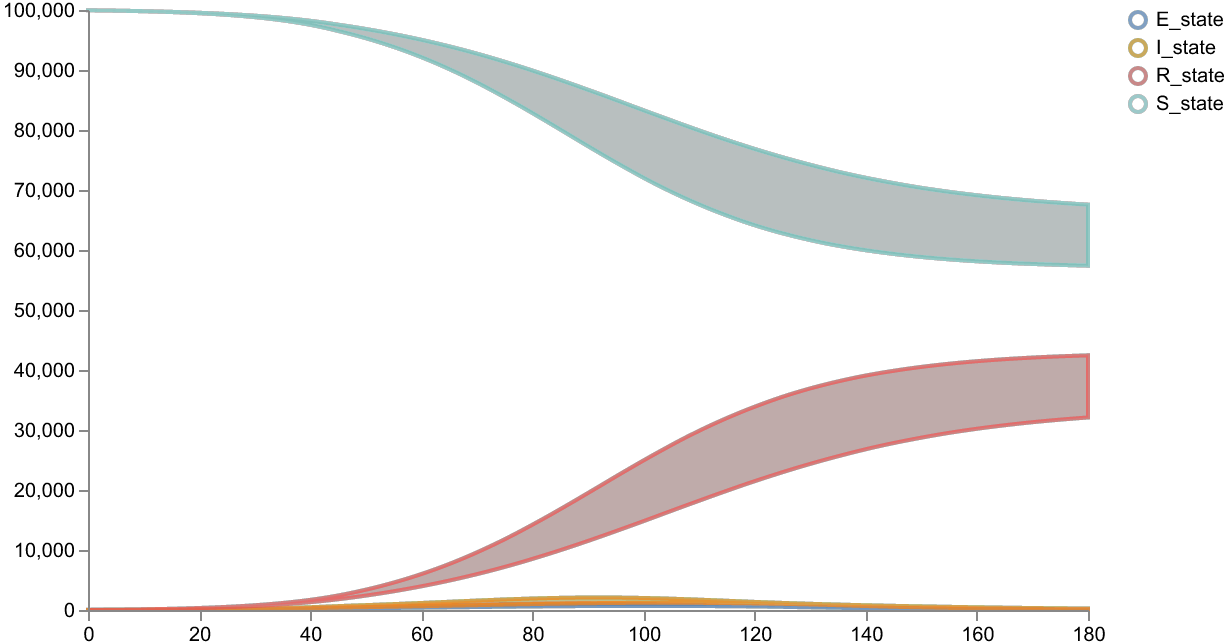

In [65]:
print("Intervention: ", static_parameter_interventions(opt_result2["policy"]))

opt_intervention_result2 = pyciemss.sample(
    model,
    end_time,
    logging_step_size,
    num_samples,
    start_time=start_time,
    inferred_parameters=parameter_estimates,
    static_parameter_interventions=static_parameter_interventions(opt_result2["policy"]),
)

# display(result1["data"])
print("Risk associated with QoI:", opt_intervention_result2["risk"][observed_params[0]]["risk"])

# Plot result
schema = plots.trajectories(
    opt_intervention_result2["data"], 
    keep=".*_state", 
)
img = plots.ipy_display(schema, format="png")
with open("figures/seir_optimized2.png", "wb") as png:
    png.write(img.data)
plots.ipy_display(schema, dpi=150)

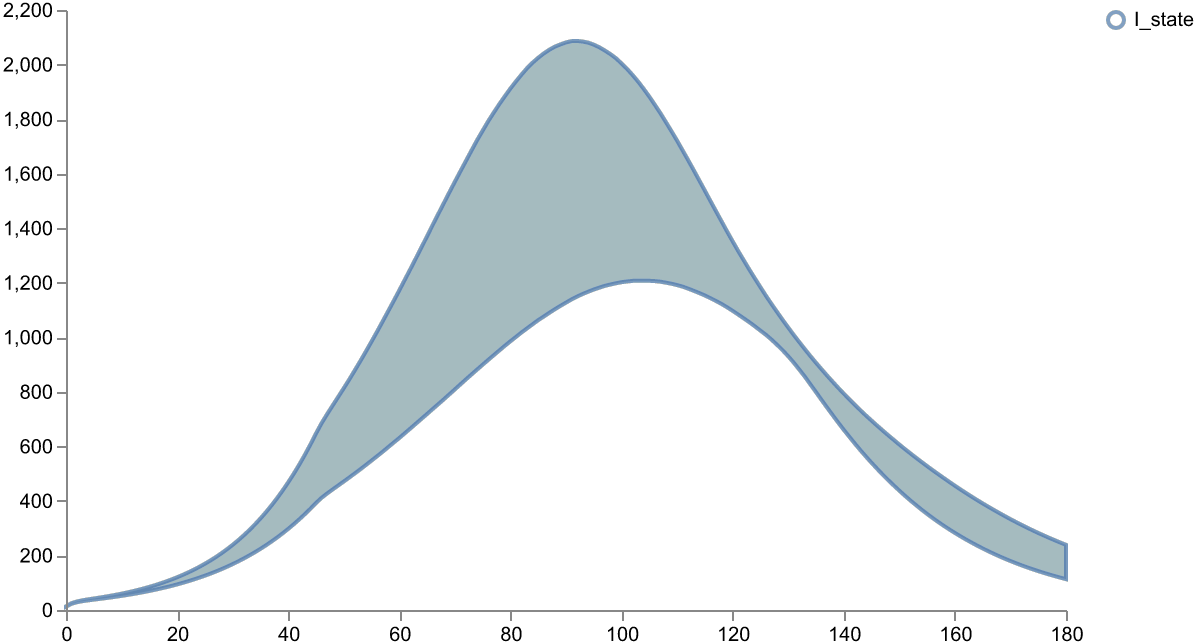

In [66]:
schema = plots.trajectories(
    opt_intervention_result2["data"], 
    keep="I_state", 
)
img = plots.ipy_display(schema, format="png")
with open("figures/seir_optimized_Istate2.png", "wb") as png:
    png.write(img.data)
plots.ipy_display(schema, dpi=150)

# Optimize start time with intervention to reduce transmission by 20%

In [67]:
initial_guess_interventions = 0.1
bounds_interventions = [[start_time], [45.0]]

risk_bound = 3500.0
qoi = lambda y: obs_max_qoi(y, observed_params)
objfun = lambda x: -x

static_parameter_interventions = start_time_objective(
    param_name = intervened_params,
    param_value = torch.tensor([0.8*current_param_value]),
)
opt_result2 = pyciemss.optimize(
    model,
    end_time,
    logging_step_size,
    qoi,
    risk_bound,
    static_parameter_interventions,
    objfun,
    initial_guess_interventions=initial_guess_interventions,
    bounds_interventions=bounds_interventions,
    start_time=start_time,
    inferred_parameters=parameter_estimates,
    n_samples_ouu=num_samples_ouu,
    maxiter=maxiter,
    maxfeval=maxfeval
)

print(f'Optimal policy:', opt_result2["policy"])
print(opt_result2)

/Users/oost464/Local_Project/pyciemss/pyciemss/ouu/ouu.py:127: UserWarning: Selected interventions are out of bounds. Will use a penalty instead of estimating risk.
  warnings.warn(
/Users/oost464/Local_Project/pyciemss/pyciemss/ouu/ouu.py:127: UserWarning: Selected interventions are out of bounds. Will use a penalty instead of estimating risk.
  warnings.warn(
/Users/oost464/Local_Project/pyciemss/pyciemss/ouu/ouu.py:127: UserWarning: Selected interventions are out of bounds. Will use a penalty instead of estimating risk.
  warnings.warn(
/Users/oost464/Local_Project/pyciemss/pyciemss/ouu/ouu.py:127: UserWarning: Selected interventions are out of bounds. Will use a penalty instead of estimating risk.
  warnings.warn(
/Users/oost464/Local_Project/pyciemss/pyciemss/ouu/ouu.py:127: UserWarning: Selected interventions are out of bounds. Will use a penalty instead of estimating risk.
  warnings.warn(
/Users/oost464/Local_Project/pyciemss/pyciemss/ouu/ouu.py:127: UserWarning: Selected inter

Optimal policy: tensor([45.], dtype=torch.float64)
{'policy': tensor([45.], dtype=torch.float64), 'OptResults':                     message: ['requested number of basinhopping iterations completed successfully']
                    success: True
                        fun: -45.0
                          x: [ 4.500e+01]
                        nit: 50
      minimization_failures: 0
                       nfev: 1235
 lowest_optimization_result: message: Optimization terminated successfully.
                             success: True
                              status: 1
                                 fun: -45.0
                                   x: [ 4.500e+01]
                                nfev: 29
                               maxcv: 0.0}


Intervention:  {45.0: {'beta': tensor([0.3040])}}
Risk associated with QoI: [array([-11776.844 , -11765.811 , -11759.762 , -11755.785 , -11752.613 ,
       -11749.688 , -11746.763 , -11743.723 , -11740.51  , -11737.09  ,
       -11733.44  , -11729.542 , -11725.375 , -11720.921 , -11716.16  ,
       -11711.072 , -11705.636 , -11699.826 , -11693.619 , -11686.988 ,
       -11679.906 , -11672.344 , -11664.269 , -11655.648 , -11646.447 ,
       -11636.629 , -11626.154 , -11614.981 , -11603.067 , -11598.595 ,
       -11593.53  , -11590.366 , -11588.352 , -11583.056 , -11577.644 ,
       -11576.83  , -11572.111 , -11566.461 , -11562.41  , -11560.6875,
       -11554.791 , -11548.772 , -11547.051 , -11542.629 , -11536.359 ,
       -11530.698 , -11529.964 , -11523.442 , -11516.793 , -11513.295 ,
       -11510.016 , -11503.109 , -11496.076 , -11494.781 , -11488.914 ,
       -11481.623 , -11475.094 , -11474.205 , -11466.66  , -11458.987 ,
       -11454.168 , -11451.189 , -11443.267 , -11435.221 , 

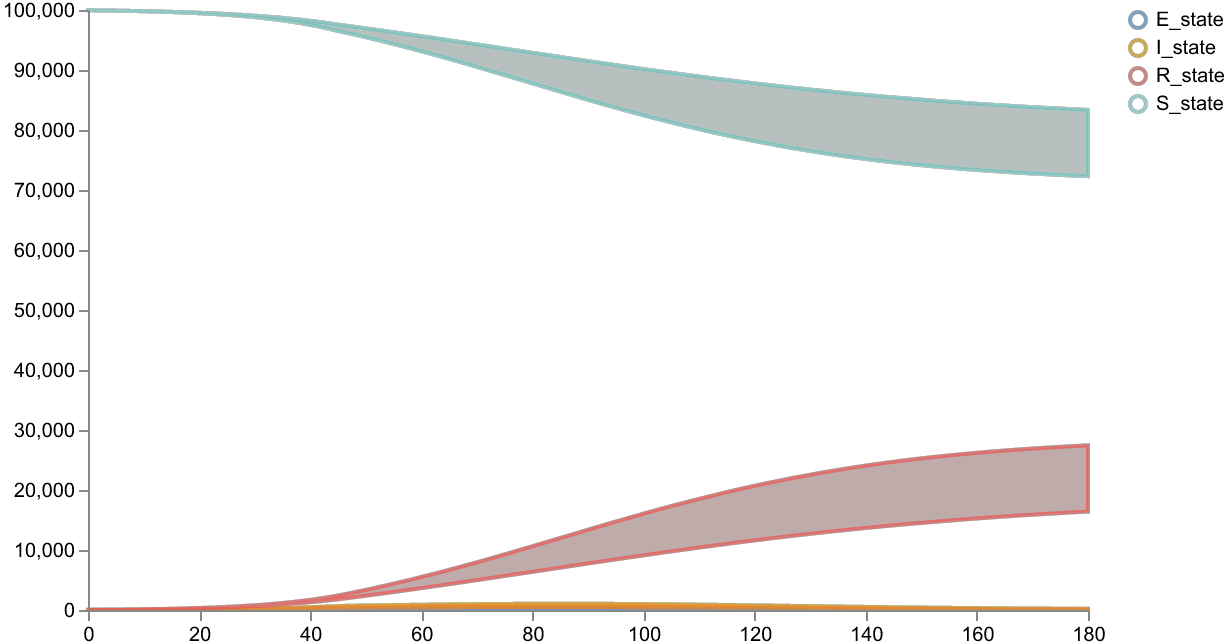

In [68]:
print("Intervention: ", static_parameter_interventions(opt_result2["policy"]))

opt_intervention_result2 = pyciemss.sample(
    model,
    end_time,
    logging_step_size,
    num_samples,
    start_time=start_time,
    inferred_parameters=parameter_estimates,
    static_parameter_interventions=static_parameter_interventions(opt_result2["policy"]),
)

# display(result1["data"])
print("Risk associated with QoI:", opt_intervention_result2["risk"][observed_params[0]]["risk"])

# Plot result
schema = plots.trajectories(
    opt_intervention_result2["data"], 
    keep=".*_state", 
)
img = plots.ipy_display(schema, format="png")
with open("figures/seir_optimized2.png", "wb") as png:
    png.write(img.data)
plots.ipy_display(schema, dpi=150)

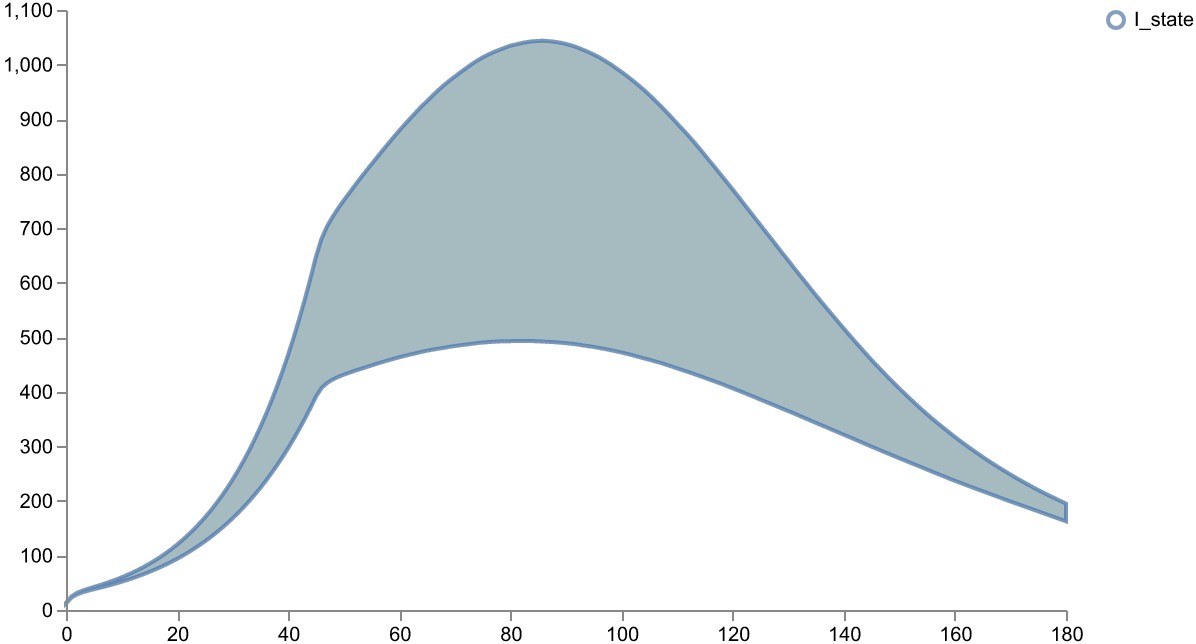

In [69]:
schema = plots.trajectories(
    opt_intervention_result2["data"], 
    keep="I_state", 
)
img = plots.ipy_display(schema, format="png")
with open("figures/seir_optimized_Istate2.png", "wb") as png:
    png.write(img.data)
plots.ipy_display(schema, dpi=150)

# Plot all I states together

In [70]:
import pandas as pd

# Assuming the dataframes are already loaded as follows:
# result['data'], calibrated_sample_result2['data'], intervened_sample_results1['data'],
# opt_intervention_result1['data'], opt_intervention_result2['data']

# Step 1: Select the relevant columns from result['data'] and rename `I_state` to `I_state_prior`
df = result['data'][['timepoint_id', 'sample_id', 'timepoint_unknown', 'I_state']]
df = df.rename(columns={'I_state': 'I_state_prior'})

# Step 2: Add the column `I_state` from calibrated_sample_result2['data'] and rename it `I_state_calibrated`
df['I_state_calibrated'] = calibrated_sample_result2['data']['I_state']

# Step 3: Add the column `I_state` from intervened_sample_results1["data"] and rename it `I_state_intervened`
df['I_state_intervened'] = intervened_sample_results1['data']['I_state']

# Step 4: Add the column `I_state` from opt_intervention_result1["data"] and rename it `I_state_opt`
df['I_state_opt'] = opt_intervention_result1['data']['I_state']

# Step 5: Add the column `I_state` from opt_intervention_result2["data"] and rename it `I_state_opt_start_time`
df['I_state_opt_start_time'] = opt_intervention_result2['data']['I_state']

# Display the final dataframe
print(df)

         timepoint_id  sample_id timepoint_unknown  I_state_prior  \
0                   0          0               0.0      10.071963   
1                   1          0               1.0      19.100512   
2                   2          0               2.0      24.092859   
3                   3          0               3.0      27.408596   
4                   4          0               4.0      30.078596   
...               ...        ...               ...            ...   
1809995           176       9999             176.0     224.854202   
1809996           177       9999             177.0     214.578445   
1809997           178       9999             178.0     204.743484   
1809998           179       9999             179.0     195.333023   
1809999           180       9999             180.0     186.331528   

         I_state_calibrated  I_state_intervened  I_state_opt  \
0                 12.921143           12.752829    12.792205   
1                 24.150877           24.03

# HELP!

- plot title (title)
- axes labels (x, y)
- change colors
- dashed lines for mean
- legend: change labels
- add vertical dashed line at time 45 for intervention
- add horizontal dashed line at I = 3500 for threshold

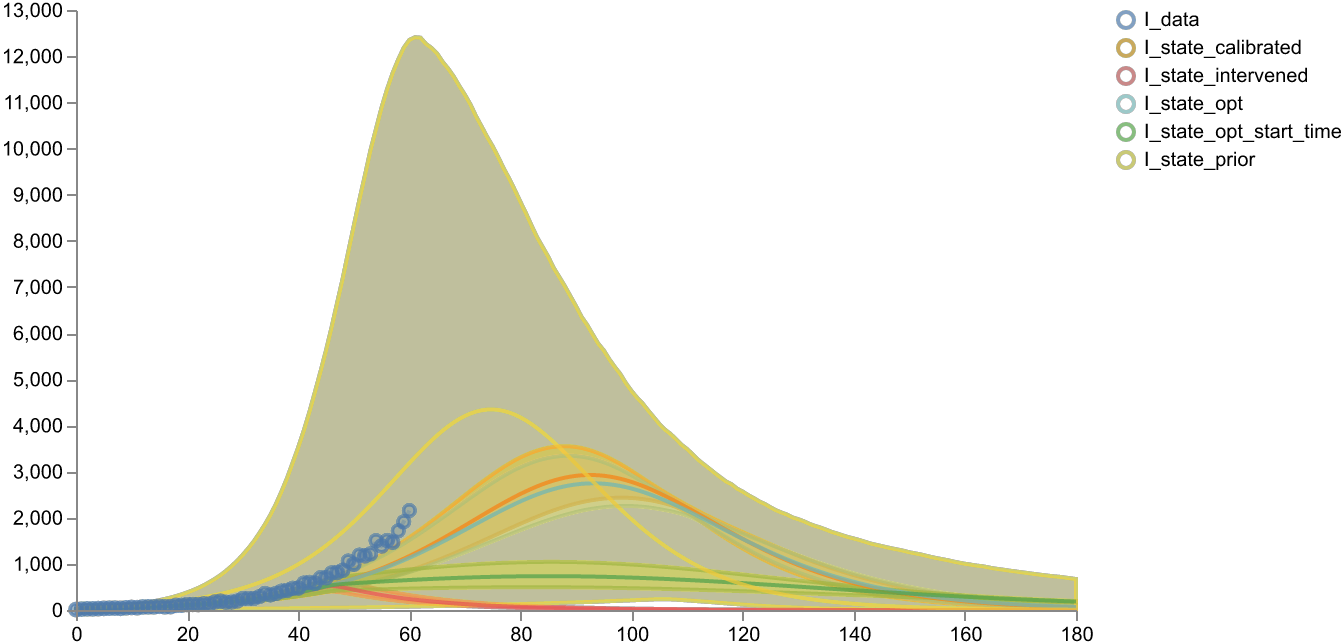

In [71]:
from pyciemss.visuals.trajectories import select_traces

relabel_dict = {
    'I_state_prior': 'Prior Distribution',
    'I_state_calibrated': 'Calibrated Distribution',
    'I_state_intervened': 'Intervened Distribution',
    'I_state_opt': 'Optimal Distribution',
    'I_state_opt_start_time': 'Optimal Start Time Distribution',
}

# Plot the mean traces
data_df = pd.read_csv(dataset)
schema = plots.trajectories(
    distributions=df,
    traces=select_traces(df, keep='.*I_state.*'),
    keep=".*I_state.*",
    points=data_df.drop(columns=['Timestamp', 'R_data']).reset_index(drop=True)
)
img = plots.ipy_display(schema, format="png")

with open("figures/seir_Istates_all.png", "wb") as png:
    png.write(img.data)

plots.ipy_display(schema, dpi=150)